## Convolutional Neural Network for MNIST image classficiation 

In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
import sys
sys.path.append("../")
from src.CNN import CNN, compute_accuracy_metrics, multiclass_accuracy_metrics, list2onehot, onehot2list

In [3]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [4]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

In [5]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=0)

# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:].reshape(1,28,28), y_train0[i,:])) 
    out.append(item)
    
# FFNN training
CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 8, # num filters for the first conv layer
           num_filt2 = 8, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

CNN0.train(lr = 0.01,
           beta1 = 0.95,
           beta2 = 0.99,
           minibatch_size = 32,
           num_epochs = 20,
           verbose = True)



In [ ]:
# CNN prediction

X_test /= np.max(X_test)
print('X_test.shape', X_test.shape)
out_test = []


for i in range(X_test.shape[0]):
    out_test.append((X_test[i,:].reshape(1,28,28)))
                
y_hat = CNN0.predict(image_list=out_test)

y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)





In [ ]:
# Simple MNIST binary classification experiments 

thickness = 10
X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=thickness)

# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:].reshape(1,28+thickness,28+thickness), y_train0[i,:])) 
    out.append(item)
    
# FFNN training
CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 8, # num filters for the first conv layer
           num_filt2 = 8, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

CNN0.train(lr = 0.01,
           beta1 = 0.95,
           beta2 = 0.99,
           minibatch_size = 32,
           num_epochs = 30,
           verbose = True)

# CNN prediction




idx = np.random.choice(np.arange(len(y_test)), 100)
X_test0 = X_test[idx, :]/np.max(X_test)
y_test0 = y_test[idx, :]

out_test = []

for i in range(X_test0.shape[0]):
    out_test.append((X_test0[i,:].reshape(1,28+thickness,28+thickness)))
                
y_hat = CNN0.predict(image_list=out_test)

y_test_label = np.asarray(onehot2list(y_test0))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)





In [ ]:
# compute comparative multiclass classification metrics on test data

thinkness = 10
n_filters = [2, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=['0','1'], 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=thinkness)
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]
    
    idx = np.random.choice(np.arange(len(y_test)), 200)
    X_test0 = X_test[idx, :]/np.max(X_test)
    y_test0 = y_test[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].reshape(1,28+thinkness,28+thinkness), y_train0[i,:])) 
        out.append(item)
        out_train.append(X_train0[i,:].reshape(1,28+thinkness,28+thinkness))
        
    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test0.shape[0]):
        out_test.append((X_test0[i,:].reshape(1,28+thinkness,28+thinkness)))

    for M in n_filters:

        # FFNN training
        CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = M, # num filters for the first conv layer
           num_filt2 = M, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

        CNN0.train(lr = 0.01,
                   beta1 = 0.95,
                   beta2 = 0.99,
                   minibatch_size = 32,
                   num_epochs = 50,
                   verbose = True)
        
        # FFNN prediction
        print()
        y_hat_train = np.asarray(CNN0.predict(out_train))
        y_hat_test = np.asarray(CNN0.predict(out_test))

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test0))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train)
        results_test = multiclass_accuracy_metrics(Y_test=y_test0, P_pred=y_hat_test)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(n_filters, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(n_filters, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of filters', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_CNN_accuracy_ex1.pdf')

## Classifying non-aligned MNIST images 

  0%|          | 0/50 [00:00<?, ?it/s]

self.img_x_dim 28
LR:0.01, MiniBatch Size:32


  2%|▏         | 1/50 [00:05<04:53,  5.99s/it]

iteration 0, error 1.60961


 12%|█▏        | 6/50 [00:36<04:33,  6.22s/it]

iteration 5, error 1.60556


 22%|██▏       | 11/50 [01:09<04:15,  6.55s/it]

iteration 10, error 1.42179


 32%|███▏      | 16/50 [01:43<03:48,  6.72s/it]

iteration 15, error 1.02099


 42%|████▏     | 21/50 [02:17<03:17,  6.80s/it]

iteration 20, error 0.60103


 52%|█████▏    | 26/50 [02:51<02:44,  6.85s/it]

iteration 25, error 0.32333


 62%|██████▏   | 31/50 [03:26<02:10,  6.87s/it]

iteration 30, error 0.33046


 72%|███████▏  | 36/50 [04:00<01:36,  6.89s/it]

iteration 35, error 0.02560


 82%|████████▏ | 41/50 [04:35<01:02,  6.92s/it]

iteration 40, error 0.08078


 92%|█████████▏| 46/50 [05:09<00:27,  6.89s/it]

iteration 45, error 0.21739


  2%|▏         | 2/100 [00:00<00:09, 10.82it/s]

100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


!!! confusion_mx [[23  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 21  0  0]
 [ 1  0  0 21  0]
 [ 0  0  0  0 13]]
!!! Accuracy 0.99
!!! confusion_mx [[21  0  0  0  0]
 [ 0 24  1  1  0]
 [ 4  0 12  2  0]
 [ 2  0  0  9  0]
 [ 4  1  0  1 18]]
!!! Accuracy 0.84


  0%|          | 0/50 [00:00<?, ?it/s]

self.img_x_dim 35
LR:0.01, MiniBatch Size:32


  2%|▏         | 1/50 [00:11<09:00, 11.03s/it]

iteration 0, error 1.60927


 12%|█▏        | 6/50 [01:05<07:56, 10.83s/it]

iteration 5, error 1.60604


 22%|██▏       | 11/50 [01:58<06:59, 10.75s/it]

iteration 10, error 1.48704


 32%|███▏      | 16/50 [02:52<06:06, 10.79s/it]

iteration 15, error 1.23380


 42%|████▏     | 21/50 [03:46<05:13, 10.80s/it]

iteration 20, error 0.93506


 52%|█████▏    | 26/50 [04:40<04:19, 10.82s/it]

iteration 25, error 1.03427


 62%|██████▏   | 31/50 [05:34<03:24, 10.78s/it]

iteration 30, error 0.77698


 72%|███████▏  | 36/50 [06:30<02:38, 11.32s/it]

iteration 35, error 0.50079


 82%|████████▏ | 41/50 [07:30<01:47, 11.93s/it]

iteration 40, error 0.42956


 92%|█████████▏| 46/50 [08:32<00:49, 12.34s/it]

iteration 45, error 0.46880


 96%|█████████▌| 48/50 [08:58<00:22, 11.22s/it]


KeyboardInterrupt: 

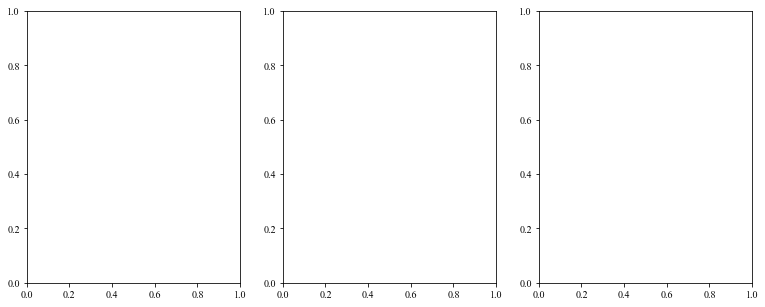

In [6]:
# compute comparative multiclass classification metrics on test data

padding_list = [0, 7, 13, 20]
list_digits=['0','1','2','3','4']

## Train
train_size_list = [50, 100, 200]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        # Data preprocessing
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                           full_MNIST=[X,y], 
                                                                           padding_thickness=thickness)
            
        idx = np.random.choice(np.arange(len(y_train)), train_size)
        X_train0 = X_train[idx, :]/np.max(X_train)
        y_train0 = y_train[idx, :]

        
        
        idx = np.random.choice(np.arange(len(y_test)), 100)
        X_test0 = X_test[idx, :]/np.max(X_test)
        y_test0 = y_test[idx, :]

        out = []
        out_train = []
        # populate the tuple list with the data
        for i in range(X_train0.shape[0]):
            item = list((X_train0[i,:].reshape(1, 28+thickness, 28+thickness), y_train0[i,:])) 
            
            out.append(item)
            out_train.append(X_train0[i,:].reshape(1, 28+thickness, 28+thickness))

        X_test /= np.max(X_test)
        out_test = []
        for i in range(X_test0.shape[0]):
            out_test.append((X_test0[i,:].reshape(1, 28+thickness, 28+thickness)))
    
    
    
        # FFNN training
        CNN0 = CNN(training_data = out,
           f = 5, # conv filter dim
           f_pool = 2, # maxpool filter dim
           num_filt1 = 10, # num filters for the first conv layer
           num_filt2 = 10, # num filters for the second conv layer
           conv_stride = 1,
           pool_stride = 2,
           hidden_nodes = 128)

        CNN0.train(lr = 0.01,
                   beta1 = 0.95,
                   beta2 = 0.99,
                   minibatch_size = 32,
                   num_epochs = 50,
                   verbose = True)

        # FFNN prediction
        print()
        y_hat_train = np.asarray(CNN0.predict(out_train))
        y_hat_test = np.asarray(CNN0.predict(out_test))

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test0))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train)
        results_test = multiclass_accuracy_metrics(Y_test=y_test0, P_pred=y_hat_test)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_CNN_accuracy_padding_ex2.pdf')